# **create calss neuron**

In [47]:
import numpy as np
from scipy.stats import norm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
np.random.seed(42)

In [48]:
# Radial basis neurons
class Hidden_Neuron:
    def __init__(self, center, spread):
        # Initialize center and spread (width)
        self.c = center
        self.s = spread

    # Activation function using Gaussian (RBF)
    def activate(self, x):
        # Calculate Euclidean distance from input x to center c
        distance = np.linalg.norm(np.array(x) - np.array(self.c))
        # Gaussian function (RBF activation)
        return np.exp(- (distance ** 2) / (2 * self.s ** 2) )

In [49]:
# Output neurons
class Neuron:
    def __init__(self, input_dim):
        # Initialize weights and bias
        self.bias = np.random.uniform(-0.5, 0.5)
        self.weights = [np.random.uniform(-0.5, 0.5) for _ in range(input_dim)]

    def activate(self, inputs):
        # Calculate the weighted sum of the inputs plus the bias
        weighted_sum = sum(w * x for w, x in zip(self.weights, inputs)) + self.bias
        return weighted_sum

In [50]:
class RBF_net:
    def __init__(self, num_of_hidden_neurons, num_of_out_neurons, input_dim):
        self.num_of_hidden_neurons = num_of_hidden_neurons
        self.input_dim = input_dim

        # Initialize output layer of standard neurons
        self.output_layer = [Neuron(num_of_hidden_neurons) for _ in range(num_of_out_neurons)]
        # Placeholder for hidden layer, to be filled after center/width adjustment
        self.hidden_layer = []
        self.output_hidden_layer = []  # Stores activations for backpropagation

    def activate(self, pattern):
        # Activate the hidden layer neurons
        self.output_hidden_layer = [neuron.activate(pattern) for neuron in self.hidden_layer]
        # Activate the output layer neurons based on hidden layer outputs
        output = [neuron.activate(self.output_hidden_layer) for neuron in self.output_layer]
        return output

    def adjust_centers_and_widths(self, training_data):
        # Step 1: Use K-means to find centers
        kmeans = KMeans(n_clusters=self.num_of_hidden_neurons)
        kmeans.fit(training_data)
        centers = kmeans.cluster_centers_

        # Step 2: Calculate widths based on the average distance to the nearest neighbor
        widths = []
        for i, center in enumerate(centers):
            # Find the distance to the nearest other center
            distances = [np.linalg.norm(center - other_center) for j, other_center in enumerate(centers) if i != j]
            nearest_neighbor_distance = np.mean(distances)
            widths.append(nearest_neighbor_distance / np.sqrt(2))  # Heuristic for spread

        # Step 3: Create the hidden layer neurons with calculated centers and widths
        self.hidden_layer = [Hidden_Neuron(center, width) for center, width in zip(centers, widths)]

# Method chosen: Adjust centers using K-means clustering.
# Widths are set using the average distance to nearest neighbors divided by sqrt(2).




In [51]:
def backpropagation_step(rbf_net, pattern, teacher, learning_rate):
    # Compute network output
    output = rbf_net.activate(pattern)

    # Iterate over the output and compute delta
    for i, neuron in enumerate(rbf_net.output_layer):
        # Compute delta for output neuron i
        delta = teacher[i] - output[i]

        # Update weights and bias
        for j in range(len(neuron.weights)):
            neuron.weights[j] += learning_rate * delta * rbf_net.output_hidden_layer[j]

        # Update the bias
        neuron.bias += learning_rate * delta

    return

In [52]:
def evaluate_rbf_net(rbf_net, test_data, test_targets):
    total_error = 0
    for pattern, teacher in zip(test_data, test_targets):
        output = rbf_net.activate(pattern)
        error = np.array(teacher) - np.array(output)
        total_error += np.mean(error ** 2)

    mse = total_error / len(test_data)
    print(f"Test Data MSE: {mse:.4f}")
    return mse


In [53]:
def train_rbf_net(rbf_net, training_data, targets, learning_rate, epochs):
    learning_curve = []  # Store MSE for each epoch to plot

    for epoch in range(epochs):
        total_error = 0  # To accumulate error over the epoch

        for pattern, teacher in zip(training_data, targets):
            # Compute the current output and error
            output = rbf_net.activate(pattern)
            error = np.array(teacher) - np.array(output)
            total_error += np.mean(error ** 2)  # Sum of Mean Squared Errors (MSE) for each pattern

            # Perform a backpropagation step for each pattern
            backpropagation_step(rbf_net, pattern, teacher, learning_rate)

        # Average error for the epoch
        average_error = total_error / len(training_data)
        learning_curve.append(average_error)  # Append to learning curve list
        if epoch % 10 == 0:  # Print error every 10 epochs
            print(f"Epoch {epoch + 1}/{epochs}, Total Error (MSE): {average_error:.4f}")

    # Plot the learning curve without markers
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), learning_curve, label='Learning Curve')  # Smooth line without markers
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid()
    plt.legend()
    plt.show()


Epoch 1/100, Total Error (MSE): 0.0643
Epoch 11/100, Total Error (MSE): 0.0399
Epoch 21/100, Total Error (MSE): 0.0371
Epoch 31/100, Total Error (MSE): 0.0347
Epoch 41/100, Total Error (MSE): 0.0325
Epoch 51/100, Total Error (MSE): 0.0306
Epoch 61/100, Total Error (MSE): 0.0288
Epoch 71/100, Total Error (MSE): 0.0273
Epoch 81/100, Total Error (MSE): 0.0259
Epoch 91/100, Total Error (MSE): 0.0247


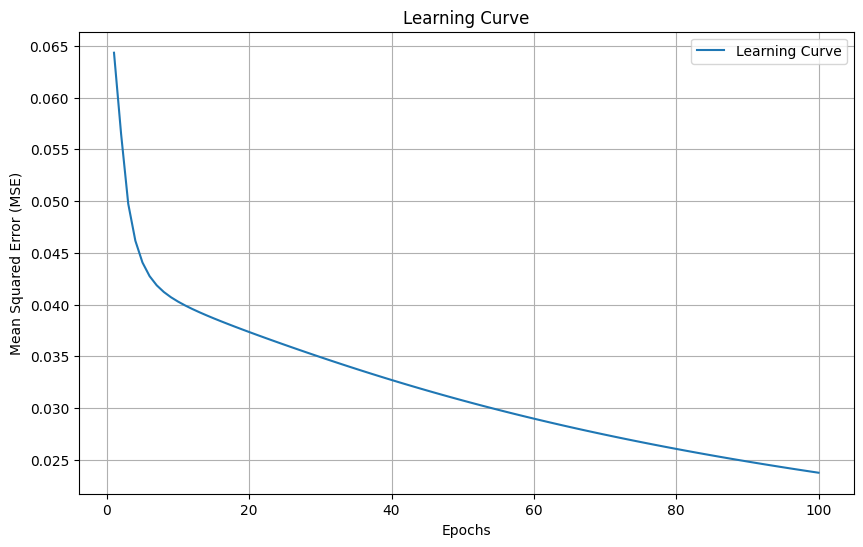

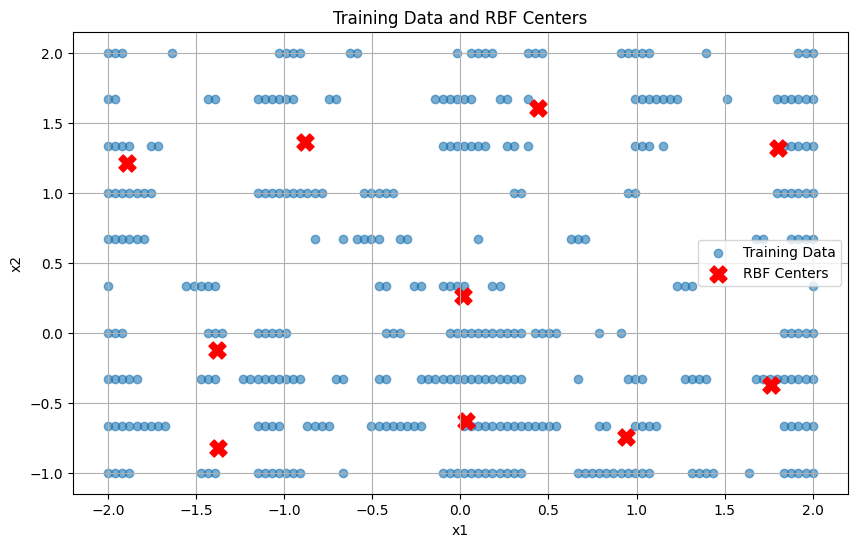

Test Data MSE: 0.0246


0.024569781535203252

In [54]:
# Load training and test data
training_data = np.loadtxt("/content/PA-A_training_data_04.txt", comments="#")
X_train = training_data[:, :2]  # Inputs
y_train = training_data[:, 2:]  # Targets



# Initialize RBF Network
num_hidden_neurons = 10
num_output_neurons = 1
input_dim = X_train.shape[1]

rbf_net = RBF_net(num_hidden_neurons, num_output_neurons, input_dim)

# Adjust centers and widths
rbf_net.adjust_centers_and_widths(X_train)

# Train the RBF network
learning_rate = 0.01
epochs = 100
train_rbf_net(rbf_net, X_train, y_train, learning_rate, epochs)

# Evaluate on test data

# Plot training data and RBF centers
centers = np.array([neuron.c for neuron in rbf_net.hidden_layer])  # Extract centers

plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], label='Training Data', alpha=0.6, marker='o')
plt.scatter(centers[:, 0], centers[:, 1], color='red', label='RBF Centers', marker='X', s=150)
plt.title('Training Data and RBF Centers')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.show()

evaluate_rbf_net(rbf_net, X_train, y_train)


In [55]:
test_data = np.loadtxt("test data.txt", comments="#")
X_test = test_data[:, :2]  # Inputs
y_test = test_data[:, 2:]  # Targets
# Evaluate on test data
evaluate_rbf_net(rbf_net, X_test, y_test)

FileNotFoundError: test data.txt not found.